## Ejercicio 4

In [6]:
from qiskit import IBMQ

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_jakarta')
print(backend)

ibmq_jakarta


### Qiskit - QFT

Al igual que en el ejercicio 3, vamos a crear una función que nos devuelva un circuito para la QFT, y otra que nos devuelva la parte intermedia del sumador de Draper:

In [130]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from math import pi

def QFT(circuit, N):

    for i in range(N):
        circuit.h(i)
        for j in range(i + 1, N):
            circuit.crz(pi*0.5**(j-i), j, i)

def adder(circuit, N):
    
    for i in range(N):
        for j in range(i, N):
            circuit.crz(pi*0.5**(j-i), N + j, i)

Inicializamos los qubits operando al valor que queremos.

In [131]:
a_ini = 0b011 # Primer operando: 3
b_ini = 0b010  # Segundo operando: 1

N = 3 # Número de qubits por operando.

# Qubits operando
A = QuantumRegister(N, name='a')        
B = QuantumRegister(N, name='b')

# Registro clásico donde mediremos el resultado.
C = ClassicalRegister(N, name='c')

init_circuit = QuantumCircuit(A, B, C)

# Inicializamos los qubits opreando al valor que deseamos.
for i in range(N):
    
    if ((a_ini >> N - i - 1) & 0x1) == 1:
        init_circuit.x(A[i])

    if (b_ini >> N - i - 1 & 0x1) == 1:
        init_circuit.x(B[i])

# init_circuit.draw(output='mpl')

Ahora, creamos un circuito que implemente por completo el sumador de Draper.

In [132]:
from qiskit import QuantumRegister, ClassicalRegister


circ = QuantumCircuit(A, B, C)

# Hacemos la QFT del primer operando.
QFT(circ, N)
qft_inv = circ.inverse()

# circ.barrier()
adder(circ, N)
# circ.barrier()

circ.compose(qft_inv, inplace=True)

# ????
for i in range(N):
    circ.measure(A[i], C[N - i - 1])

Combinamos el circuito de inicialización con el del sumador:

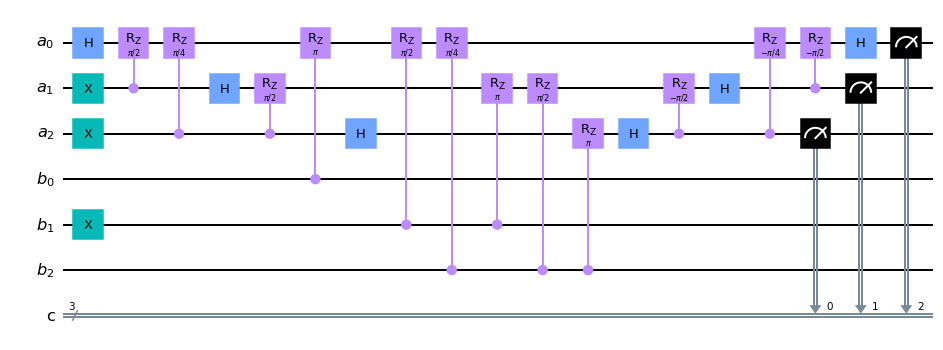

In [133]:
sumador = init_circuit.compose(circ)
sumador.draw(output='mpl', fold=-1)

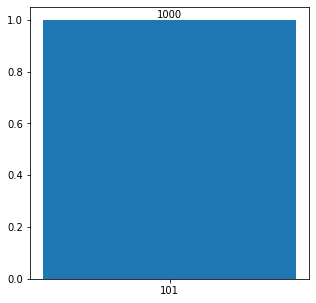

In [121]:
from qiskit import Aer, execute


simulator = Aer.get_backend('qasm_simulator')

# Ejectuamos la simulación con ruido
job = execute(sumador, simulator, shots=1000)
counts = job.result().get_counts()

plot_histogram(counts)

Ejecutamos el circuito en el *ibmq_jakarta*

In [136]:
from qiskit import transpile

transpiled = transpile(sumador, backend=backend)

job = backend.run(transpiled)
print('Job ID:', job.job_id())

Job ID: 6238dc13ecc413b493b709d3


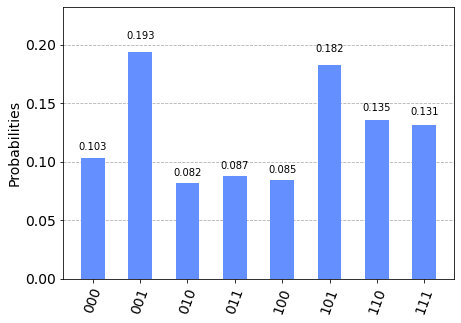

In [137]:
from qiskit.visualization import plot_histogram

result = backend.retrieve_job('6238dc13ecc413b493b709d3').result().get_counts()
plot_histogram(result)

In [138]:
transpiled.depth()

68

### Qiskit- AQFT

Vamos a definir una función para crear el circuito de la AQFT. Como la parte intermedia del circuito no cambia, podemos usar la misma función de antes

In [85]:
def AQFT(circuit, N, n_rot=2):

    for i in range(N):
        circuit.h(i)
        for j in range(i + 1, min(i+n_rot+1, N)):
            circuit.crz(pi*0.5**(j-i), j, i)

Como antes, inicializamos los qubits a los valores que queremos sumar.

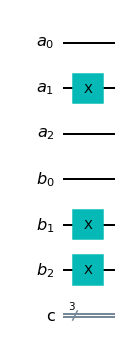

In [86]:
a_ini = 0b010  # Primer operando: 2
b_ini = 0b011   # Segundo operando: 3

N = 3 # Número de qubits por operando.

# Qubits operando
A = QuantumRegister(N, name='a')        
B = QuantumRegister(N, name='b')

# Registro clásico donde mediremos el resultado.
C = ClassicalRegister(N, name='c')

init_circuit = QuantumCircuit(A, B, C)

# Inicializamos los qubits opreando al valor que deseamos.
for i in range(N):
    
    if ((a_ini >> N - i - 1) & 0x1) == 1:
        init_circuit.x(A[i])

    if (b_ini >> N - i - 1 & 0x1) == 1:
        init_circuit.x(B[i])

init_circuit.draw(output='mpl')

Ahora creamos el resto del circuito.

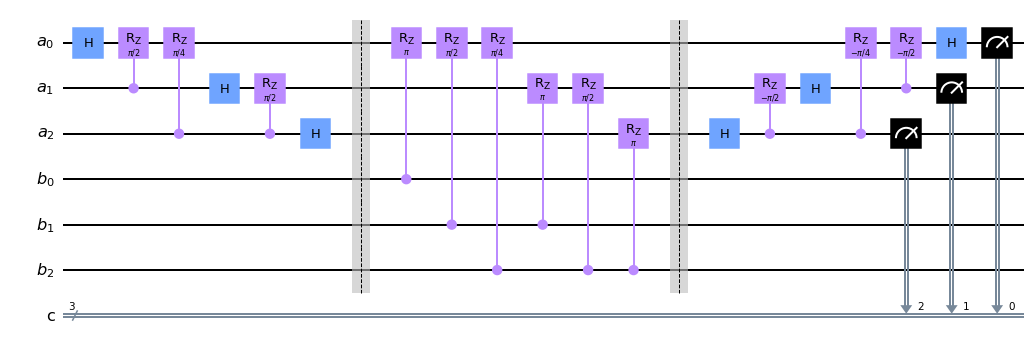

In [93]:
from qiskit import QuantumRegister, ClassicalRegister

circ = QuantumCircuit(A, B, C)

# Hacemos la QFT del primer operando.
AQFT(circ, N, n_rot=2)
inv = circ.inverse()

circ.barrier()

adder(circ, N)
circ.barrier()

circ.compose(inv, inplace=True)

circ.measure(A, C)
circ.draw(output='mpl', fold=-1)

Vemos que, como usamos 3 qubits, y el número de rotaciones de lq AQFT es 2, el circuito es idéntico al de la QFT.

Unimos los circuito de inicialicación y el del sumador.

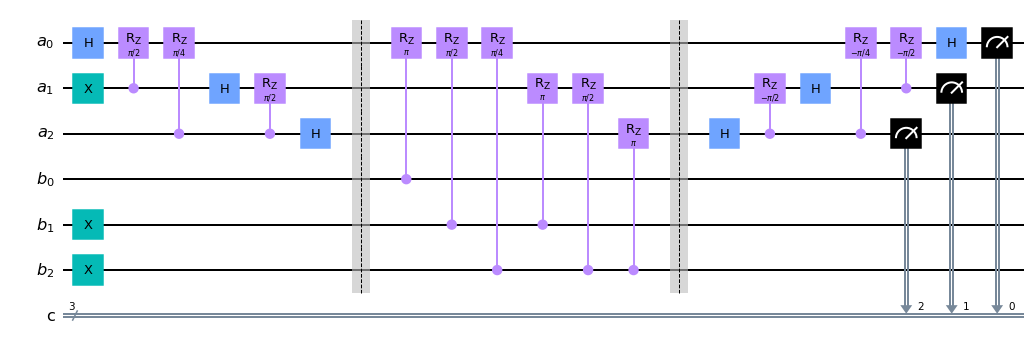

In [96]:
sumador_aqft = init_circuit.compose(circ)
sumador_aqft.draw(output='mpl', fold=-1)

Ejecutamos el código en el ibmq_jakarta.

In [97]:
transpiled = transpile(sumador_aqft, backend)

job = backend.run(transpiled)
print('Job ID:', job.job_id())

Job ID: 6238d6ae0af65d12cad9263a


Recogemos los resultados y los dibujamos.

In [99]:
from qiskit.visualization import plot_histogram

result = backend.retrieve_job('6238d6ae0af65d12cad9263a').result()
result.get_counts()

{'000': 705,
 '001': 341,
 '010': 576,
 '011': 897,
 '100': 287,
 '101': 288,
 '110': 295,
 '111': 611}

### Braket - QFT

Definimos nuestra función para la QFT, la parte intermedia del sumador, y la QFT inversa (No he encontrado nada para calcular la inversa de un circuito automáticamente con Braket).

In [102]:
from braket.circuits import Circuit

from math import pi

def QFT(circuit: Circuit, N):
    
    for i in range(N):
        circuit.h(i)
        for j in range(i + 1, N):
            circuit.cphaseshift(j, i, pi*0.5**(j-i))

def adder(circuit, N):
    for i in range(N):
        for j in range(i, N):
            circuit.cphaseshift(N + j, i, pi*0.5**(j-i))

def IQFT(circuit, N):
    
    for i in reversed(range(N)):    
         
        for j in reversed(range(i + 1, N)):
            circuit.cphaseshift(j, i, -pi*0.5**(j-i))
        circuit.h(i)   
        
        

Definimos una función para darle el varor inicial deseado a los qubits.

In [103]:
def init_qubits(circuit, A, B,  N):

    # Inicializamos los qubits opreando al valor que deseamos.
    for i in range(N):
        
        if ((A >> N - i - 1) & 0x1) == 1:
            circuit.x(i)

        if (B >> N - i - 1 & 0x1) == 1:
            circuit.x(N + i)

Usando estas funciones podemos crear el circuito entero del sumador de Draper:

In [104]:
N = 4

aspen_circ = Circuit()

# # Inicializamos los qubits.
init_qubits(aspen_circ, 0b0011, 0b0101, N)

# Añadimos la QFT al primer operando
QFT(aspen_circ, N)

# # Añadimos la parte intermedia del sumador
adder(aspen_circ, N)

# Deshacemos la QFT del primer operando.
IQFT(aspen_circ, N)

Lanzamos el código al Aspen-M1.

In [100]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice

# Necesitamos configurar la región a us-west-1
device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-11")
s3_folder = ("amazon-braket-f085dc433a90", "apcc2022/JulianCamara/Rigetti")

task = device.run(aspen_circ, s3_folder)
print("Task:",task.id)
print("Status:", task.state())

NameError: name 'aspen_circ' is not defined

In [105]:
from collections import Counter

results = task.result().measurements

# # Se muestran los resultados.
results = Counter([''.join(str(i) for i in x[:4]) for x in results])
plot_histogram(results, width=20)

NameError: name 'task' is not defined

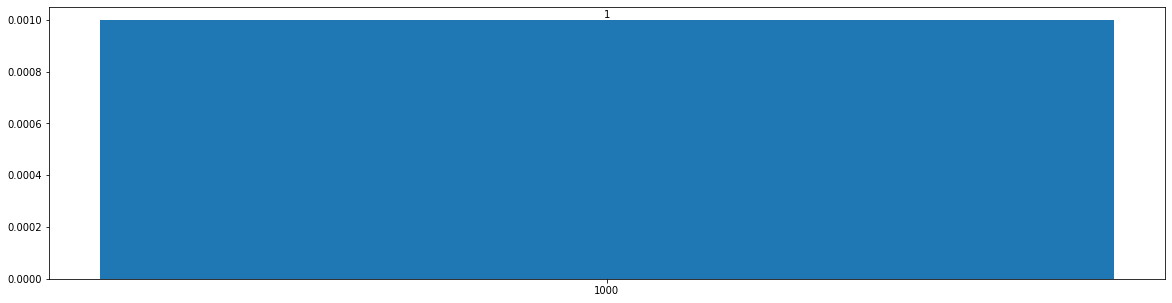

In [109]:
from braket.devices import LocalSimulator
sim = LocalSimulator()

resultXX = sim.run(aspen_circ, shots=1000).result().measurement_counts
results = Counter([''.join(str(i) for i in x[:4]) for x in resultXX])
plot_histogram(results, width=20)